In [1]:
# Importe les modules
import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#  Analyse des prénoms en France entre 1900 et 2022

## Sommaire

* [Informations](#1)
* [Vérification et prétraitement](#2)
* [Analyse descriptive](#3)
    * [Informations générales](#3-1)
    * [Tops 10](#3-2)
    * [Evolution des prénoms](#3-3)
    * [Dispersion](#3-4)
    * [Répartition](#3-5)
* [Outil intéractif INSEE](#4)
    * [Classement](#4-1)
    * [Graphique](#4-2)
* [Recherches](#5)

## Informations<a id='1'></a>

* Source : INSEE
* Fichier paru le : 04/07/2023

Le fichier des prénoms contient des données sur les prénoms attribués aux enfants nés en France entre 1900 et 2022 (les données avant 2012 ne concernent que France hors Mayotte) et les effectifs par sexe associés à chaque prénom. Ces données sont disponibles au niveau France et par département.

&#x26A0; Le fichier des prénoms est établi à partir des seuls bulletins de naissance des personnes nées en France (métropole et départements d’outre-mer). En conséquence, l’exhaustivité n’est pas garantie sur toute la période, notamment pour les années antérieures à 1946. Les utilisateurs pourront donc constater des écarts avec le nombre annuel des naissances évalué par l'Insee. Ces écarts, importants en début de période, vont en s’amenuisant. Après 1946, ils sont peu significatifs.

Pour chaque prénom, il est indiqué pour chaque année de naissance (de 1900 à 2022) et chaque sexe, le nombre de personnes inscrites à l'état civil sous ce prénom. Pour le fichier « DPT2022 », la précision est apportée pour chaque département.

**Les personnes prises en compte**

Le champ couvre l'ensemble des personnes nées en France (y compris Mayotte à partir de 2013) et enregistrées à l'état civil sur les bulletins de naissance. Les personnes nées à l'étranger sont exclues.

**Le champ des prénoms retenus**

Dans les fichiers de l’état civil, en l'occurrence les bulletins de naissance, les différents prénoms sont séparés par une espace (ou blanc). Ainsi deux prénoms séparés par un tiret constituent un seul prénom composé (exemple : Anne-Laure). Le premier prénom simple ou composé figure en début de liste, et c'est celui qui sera retenu après le traitement de la protection de l'anonymat.

**Conditions portant sur les prénoms retenus**

1. Sur la période allant de 1900 à 1945, le prénom a été attribué au moins 20 fois à des personnes de sexe féminin et/ou au moins 20 fois à des personnes de sexe masculin.
2. Sur la période allant de 1946 à 2021, le prénom a été attribué au moins 20 fois à des personnes de sexe féminin et/ou au moins 20 fois à des personnes de sexe masculin.
3. Pour une année de naissance donnée, le prénom a été attribué au moins 3 fois à des personnes de sexe féminin ou de sexe masculin.

Les effectifs des prénoms ne remplissant pas les conditions 1 et 2 sont regroupés (pour chaque sexe et chaque année de naissance) dans un enregistrement dont le champ prénom (PREUSUEL) prend la valeur «\_PRENOMS_RARES\_». Les effectifs des prénoms remplissant la condition 2 mais pas la condition 3 sont regroupés (pour chaque sexe et chaque prénom) dans un enregistrement dont le champ année de naissance (ANNAIS) prend la valeur «XXXX».

**Dictionnaire des variables**

Le fichier départemental comporte **703 007** enregistrements et **quatre variables** décrites ci-après.

|Nom|Intitulé|Type|Longueur|Modalité|
|---|--------|----|--------|--------|
|SEXE|sexe|caractère|1|1 pour masculin, 2 pour féminin|
|PREUSUEL|premier prénom|caractère|25||
|ANNAIS|année de naissance|caractère|4|1900 à 2021, XXXX|
|NOMBRE|fréquence|numérique|8||

## Vérification et prétraitement<a id='2'></a>

In [2]:
# Importe le DataFrame
df_prenoms = pd.read_csv('./datasets/nat2022.csv', sep=';')

In [3]:
# Affiche un aperçu des données
df_prenoms.head()

,sexe,preusuel,annais,nombre
0,1,_PRENOMS_RARES,1900,1249
1,1,_PRENOMS_RARES,1901,1342
2,1,_PRENOMS_RARES,1902,1330
3,1,_PRENOMS_RARES,1903,1286
4,1,_PRENOMS_RARES,1904,1430


In [4]:
# Affiche un échantillon des données
df_prenoms.sample(5)

,sexe,preusuel,annais,nombre
344774,2,ANGELIKA,2009,10
211782,1,MHAMED,1987,6
106265,1,GAYLOR,2005,11
28122,1,ARAS,2007,4
579361,2,MELANY,1976,3


In [5]:
# Affiche les dimension du dataset
df_prenoms.shape

(703007, 4)

Le *DataFrame* `df_prenom` a des dimensions qui correspondent aux informations fournies par l'INSEE donc l'importation semble s'être bien passée.

Certaines variables vont être renommées et on va également remplacer les modalités de la variables « sexe » par leur signification. L'ojectif est de faciliter la compréhension.

In [6]:
# Renomme les variables
df_prenoms = df_prenoms.rename(
    columns={'sexe': 'genre', 'preusuel': 'prenom', 'annais': 'annee'})

# Remplace les modalités de 'genre'
df_prenoms['genre'] = df_prenoms['genre'].map({1: 'm', 2: 'f'})

In [7]:
df_prenoms.sample(3)

,genre,prenom,annee,nombre
634159,f,RICA,XXXX,21
136101,m,IVAN,1981,113
202786,m,MASSI,2015,7


In [8]:
df_prenoms.dtypes

genre     object
prenom    object
annee     object
nombre     int64
dtype: object

* La variable « genre » est qualitative et n'a qu'un nombre fini de modalités. On va la convertir en catégorie.
* La variable « annee », va être convertie en nombre entier. On ne la convertit pas en date car on ne prévoit pas de faire de calculs (détermination de l'âge). Elle a une longueur de 4 (voir dictionnaire), on peut donc la convertir en 16 bit.
* La variable « nombre » a une longueur de 8 (voir dictionnaire), on peut donc la convertir en 32 bit.

L'objectif de ces conversions est d'optimiser la consommation mémoire et donc d'améliorer les performances. On va afficher la consommation avant/après les conversions pour en mesurer l'impact.

In [9]:
# Affiche la consommation mémoire
df_prenoms.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703007 entries, 0 to 703006
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   genre   703007 non-null  object
 1   prenom  703005 non-null  object
 2   annee   703007 non-null  object
 3   nombre  703007 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 129.1 MB


In [10]:
# Change le type des données
try:
    df_prenoms = df_prenoms.astype(
        {
            'genre': 'category',
            'annee': 'int16',
            'nombre': 'int32'
        }
    )
except ValueError as erreur:
    print(erreur)

invalid literal for int() with base 10: 'XXXX': Error while type casting for column 'annee'


On ne peut pas convertir `annee` car des enregistrements contiennent la chaîne de caractères « XXXX ».

In [11]:
# Affiche la part des prénoms 'XXXX'
(df_prenoms.loc[df_prenoms['annee'] == 'XXXX', 'nombre'].sum()
 / df_prenoms['nombre'].sum())

0.010209364125456252

Les prénoms avec année 'XXXX' représente 1.02 % du nombre de prénoms donnés. Leur proportion est faible, on les supprime.

In [12]:
# Supprime les années 'XXXX'
df_prenoms = df_prenoms[df_prenoms['annee'] != 'XXXX']

In [13]:
# Change le type des données
df_prenoms = df_prenoms.astype(
    {
        'genre': 'category',
        'annee': 'int16',
        'nombre': 'int32'
    }
)

# Affiche la consommation mémoire
df_prenoms.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 664210 entries, 0 to 703005
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   genre   664210 non-null  category
 1   prenom  664209 non-null  object  
 2   annee   664210 non-null  int16   
 3   nombre  664210 non-null  int32   
dtypes: category(1), int16(1), int32(1), object(1)
memory usage: 51.0 MB


Grâce aux modifications de type, l'utilisation mémoire a été divisée 2.5 !

In [14]:
df_prenoms.describe(include='all')

,genre,prenom,annee,nombre
count,664210,664209,664210.000000,664210.000000
unique,2,34922,NaN,NaN
top,f,_PRENOMS_RARES,NaN,NaN
freq,360702,246,NaN,NaN
mean,NaN,NaN,1985.202861,131.359498
std,NaN,NaN,31.742724,890.367622
min,NaN,NaN,1900.000000,3.000000
25%,NaN,NaN,1967.000000,4.000000
50%,NaN,NaN,1995.000000,7.000000
75%,NaN,NaN,2011.000000,23.000000


In [15]:
# Affiche la part '_PRENOMS_RARES'
(df_prenoms.loc[df_prenoms['prenom'] == '_PRENOMS_RARES', 'nombre'].sum()
 / df_prenoms['nombre'].sum())

0.02017474050402032

L'enregistrement « _PRENOMS_RARES » a une faible part dans le jeu de données et il sera inutile dans l'analyse que nous souhaitons mener, on va donc le supprimer.

In [16]:
# Supprime les années '_PRENOMS_RARES'
df_prenoms = df_prenoms[df_prenoms['prenom'] != '_PRENOMS_RARES']

In [17]:
# Affiche le nombre de valeurs manquantes
df_prenoms.isna().sum()

genre     0
prenom    1
annee     0
nombre    0
dtype: int64

Il manque un prénom dans tout le *DataFrame*.

In [18]:
# Affiche les enregistrements avec prénom manquant
df_prenoms.loc[df_prenoms['prenom'].isna()]

,genre,prenom,annee,nombre
593279,f,NaN,2003,3


Il s'agit de toute façon d'un prénom donné seulement 3 fois en 2003, on le supprime.

In [19]:
# Supprime les enregistrements avec prénom manquant
df_prenoms = df_prenoms.dropna().reset_index(drop=True)

In [20]:
# Affiche le nombre de doublons
df_prenoms.duplicated().sum()

0

Les prénoms sont entièrement écrits en majuscules. Nous allons modifier cela afin que seule la première lettre du prénom soit en majucule. En cas de prénom composé, la première lettre de chaque prénoms qui le composent sera en majuscule.

In [21]:
df_prenoms['prenom'] = df_prenoms['prenom'].str.title()

## Analyse descriptive<a id='3'></a>

### Informations générales<a id='3-1'></a>

In [22]:
# Affiche le nombre d'années
df_prenoms['annee'].nunique()

123

genre
f    20148
m    16961
Name: prenom, dtype: int64


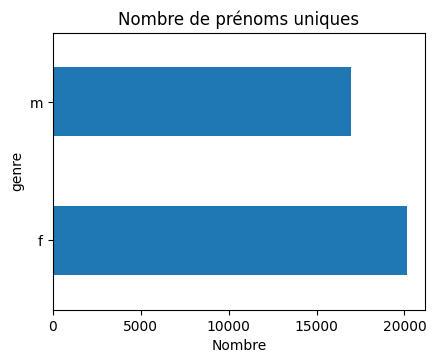

In [23]:
# Affiche le nombre de prénoms uniques par genre
print(df_prenoms.groupby('genre')['prenom'].nunique())

# Trace le nombre de prénoms uniques par genre
df_prenoms.groupby('genre')['prenom'].nunique().plot(
    kind='barh', xlabel='Nombre', title='Nombre de prénoms uniques',
    figsize=(4.8, 3.6)
)
plt.show()

genre
f    42330279
m    43159758
Name: nombre, dtype: int32


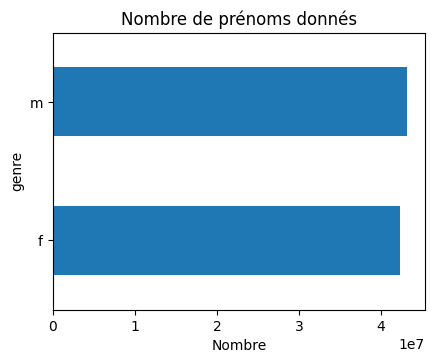

In [24]:
# Affiche le nombre de prénoms donnés par genre
print(df_prenoms.groupby('genre')['nombre'].sum())

# Trace le nombre de prénoms donnés par genre
df_prenoms.groupby('genre')['nombre'].sum().plot(
    kind='barh', xlabel='Nombre', title='Nombre de prénoms donnés',
    figsize=(4.8, 3.6)
)
plt.show()

In [25]:
# Affiche les statistiques des prénoms féminins
(df_prenoms[df_prenoms['genre'] == 'f'].groupby('prenom')['nombre'].sum()
.describe().astype(int))

count      20148
mean        2100
std        22824
min            3
25%           12
50%           41
75%          175
max      2231909
Name: nombre, dtype: int32

In [26]:
# Affiche les statistiques des prénoms masculins
(df_prenoms[df_prenoms['genre'] == 'm'].groupby('prenom')['nombre'].sum()
.describe().astype(int))

count      16961
mean        2544
std        28028
min            3
25%           11
50%           37
75%          170
max      1912567
Name: nombre, dtype: int32

### Tops 10<a id='3-2'></a>

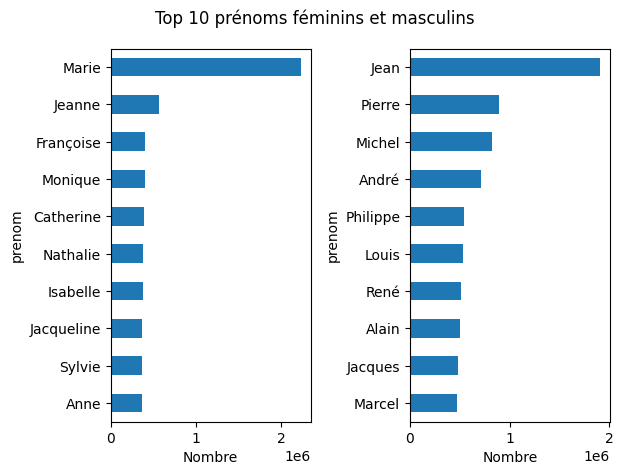

In [27]:
# Trace le top 10 des prénoms par genre
fig, axs = plt.subplots(1, 2)

(df_prenoms[df_prenoms['genre'] == 'f'].groupby('prenom')['nombre'].sum()
 .nlargest(10).sort_values().plot(kind='barh', ax=axs[0], xlabel='Nombre')
)
(df_prenoms[df_prenoms['genre'] == 'm'].groupby('prenom')['nombre'].sum()
 .nlargest(10).sort_values().plot(kind='barh', ax=axs[1], xlabel='Nombre')
)

fig.suptitle('Top 10 prénoms féminins et masculins')

fig.tight_layout()

plt.show()

### Evolution des prénoms<a id='3-3'></a>

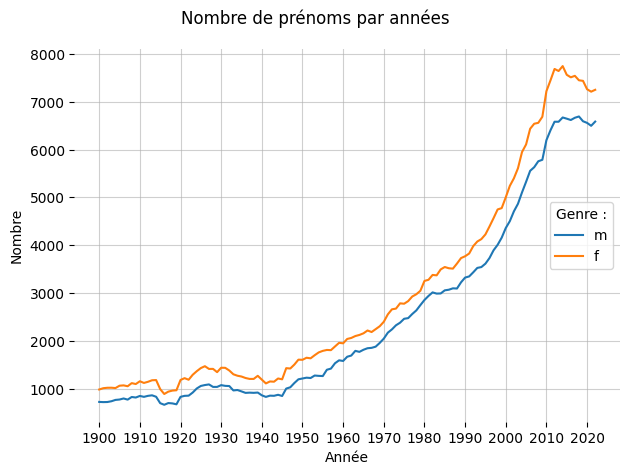

In [28]:
# Initialise le graphique
fig, ax = plt.subplots(figsize=(6.4, 4.8))

# Personnalise le graphique
ax.grid(alpha=0.6)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

for genre in df_prenoms['genre'].unique():
    df_temp = df_prenoms.loc[df_prenoms['genre'] == genre]
    df_temp = df_temp.groupby('annee')['prenom'].agg('nunique').reset_index()
    ax.plot(df_temp['annee'], df_temp['prenom'], label=genre)

# Définie la position des graduations
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

ax.set_xlabel('Année')
ax.set_ylabel('Nombre')

fig.suptitle(f'Nombre de prénoms par années')

fig.tight_layout()

plt.legend(title='Genre :', loc='center right')

plt.show()

### Dispersion<a id='3-4'></a>

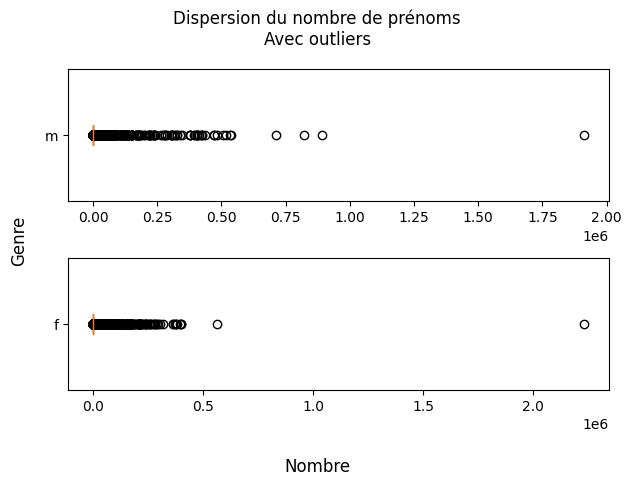

In [29]:
# Trace la dispersion du nombre de prénoms
fig, axs = plt.subplots(2, 1, figsize=(6.4, 4.8))

axs=axs.flatten()

for i, genre in enumerate(df_prenoms['genre'].unique()):
    df_temp = df_prenoms.loc[df_prenoms['genre'] == genre]
    df_temp = df_temp.groupby('prenom')['nombre'].sum().reset_index()
    axs[i].boxplot(x=df_temp['nombre'], patch_artist=True, vert=False,
                   labels=genre)

fig.supxlabel('Nombre')
fig.supylabel('Genre')

fig.suptitle(f'Dispersion du nombre de prénoms\nAvec outliers')

fig.tight_layout()

plt.show()

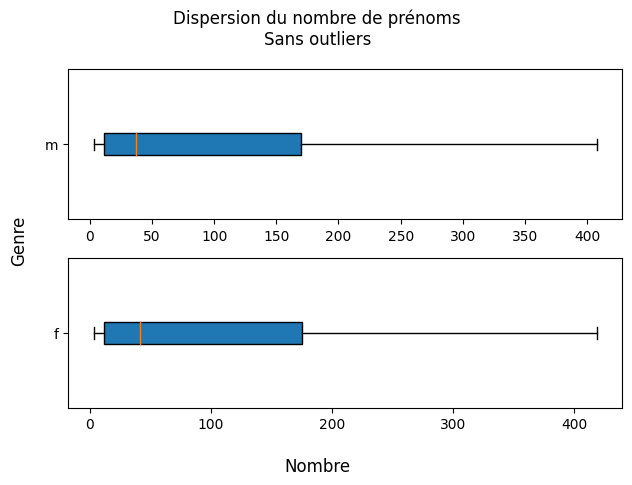

In [30]:
# Trace la dispersion du nombre de prénoms
fig, axs = plt.subplots(2, 1, figsize=(6.4, 4.8))

axs=axs.flatten()

for i, genre in enumerate(df_prenoms['genre'].unique()):
    df_temp = df_prenoms.loc[df_prenoms['genre'] == genre]
    df_temp = df_temp.groupby('prenom')['nombre'].sum().reset_index()
    axs[i].boxplot(x=df_temp['nombre'], showfliers=False, patch_artist=True,
                   vert=False, labels=genre)

fig.supxlabel('Nombre')
fig.supylabel('Genre')

fig.suptitle(f'Dispersion du nombre de prénoms\nSans outliers')

fig.tight_layout()

plt.show()

### Répartition<a id='3-5'></a>

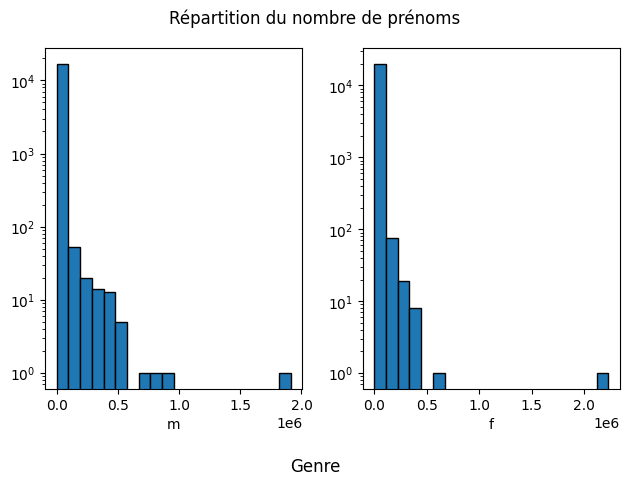

In [31]:
# Trace la répartition du nombre de prénoms
fig, axs = plt.subplots(1, 2, figsize=(6.4, 4.8))

axs=axs.flatten()

for i, genre in enumerate(df_prenoms['genre'].unique()):
    df_temp = df_prenoms.loc[df_prenoms['genre'] == genre]
    df_temp = df_temp.groupby('prenom')['nombre'].sum().reset_index()
    axs[i].hist(x=df_temp['nombre'], label=genre, bins=20, log=True,
                edgecolor='k')
    axs[i].set_xlabel(genre)
    
fig.supxlabel('Genre')

fig.suptitle(f'Répartition du nombre de prénoms')

fig.tight_layout()

plt.show()

## Outil intéractif INSEE<a id='4'></a>

Ici on reproduit l'outil intéractif de l'INSEE ([lien](https://www.insee.fr/fr/statistiques/3532172)).

### Classement<a id='4-1'></a>

In [32]:
def classement_prenoms(periode=[1900], genre=['f', 'm'], n_prenoms=10):

    # Groupe les prénoms et classe par nombre en ordre décroissant
    df_resultats = (
        (
            df_prenoms.loc[(df_prenoms['annee'].isin(periode))
                           & (df_prenoms['genre'].isin(genre))]
        ).groupby('prenom', as_index=False)['nombre'].sum()
        .nlargest(n_prenoms,'nombre')
    )

    # Ajoute le classement
    df_resultats['rang'] = (
        df_resultats['nombre'].rank(ascending=False).astype(int))

    # Crée un DataFrame temporaire
    df_temp = df_prenoms.loc[(df_prenoms['annee'].isin(periode))
                              & (df_prenoms['genre'].isin(genre))]

    # Pivote les années
    df_temp = df_temp.pivot_table(values='nombre', index='prenom',
                                  columns='annee')

    # Calcule le rang par année
    df_temp = df_temp.rank(method='min', ascending=False)

    # Récupère le meilleur rang par prénom
    meilleur_classement = list(df_temp.min(axis='columns').astype(int))

    # Calcule le rang par prénom
    df_temp = df_temp.rank(method='min', axis='columns')

    # Impute l'année si son rang est 1 sinon impute Nan
    for column in df_temp.columns:
        df_temp[column] = df_temp[column].apply(
            lambda x: str(df_temp[column].name) if x == 1 else np.nan)

    # Crée une colonne avec les années ou le classement est le meilleur
    df_temp['meilleur_classement_en'] = df_temp.apply(
        lambda x: ', '.join(x.dropna()), axis=1)

    # Crée une colonne avec le meilleur classement
    df_temp['meilleur_classement'] = meilleur_classement

    # Ajoute les informations au DataFrame des résultats
    df_resultats = pd.merge(
        df_resultats,
        df_temp[['meilleur_classement', 'meilleur_classement_en']],
        on='prenom'
    )

    return df_resultats

In [33]:
classement_prenoms(
    periode=[2018, 2019, 2020, 2021, 2022],
    genre=['f'],
    n_prenoms=10
)

,prenom,nombre,rang,meilleur_classement,meilleur_classement_en
0,Jade,18833,1,1,"2020, 2021, 2022"
1,Louise,18520,2,2,"2020, 2021, 2022"
2,Emma,18171,3,1,"2018, 2019"
3,Alice,14881,4,4,"2018, 2019, 2020"
4,Ambre,14152,5,3,2022
5,Rose,13483,6,6,"2021, 2022"
6,Lina,13352,7,5,2019
7,Chloé,12783,8,5,2018
8,Anna,12428,9,7,2021
9,Mia,11922,10,9,2020


In [34]:
classement_prenoms(
    periode=[2018, 2019, 2020, 2021, 2022],
    genre=['m'],
    n_prenoms=10
)

,prenom,nombre,rang,meilleur_classement,meilleur_classement_en
0,Gabriel,24698,1,1,"2018, 2019, 2021, 2022"
1,Léo,22055,2,1,2020
2,Raphaël,20816,3,2,2018
3,Louis,19433,4,4,"2018, 2021"
4,Arthur,18449,5,4,"2019, 2020"
5,Jules,17690,6,6,"2020, 2021"
6,Adam,17334,7,6,2018
7,Maël,16969,8,4,2022
8,Lucas,16795,9,5,2018
9,Hugo,15663,10,9,"2018, 2019"


### Graphique<a id='4-2'></a>

In [51]:
def graphique_prenoms(prenoms=['John'], genre=['m', 'f'], periode = [1900, 20022]):
    # Initialise le graphique
    fig, ax = plt.subplots(figsize=(6.4, 4.8))

    # Personnalise le graphique
    ax.grid(alpha=0.6)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)

    for prenom in prenoms:
        for genre_ in genre:
            df_temp = df_prenoms.loc[
                (df_prenoms['prenom'] == prenom)
                & (df_prenoms['genre'] == genre_)
                & (df_prenoms['annee'] >= periode[0])
                & (df_prenoms['annee'] <= periode[1])
            ].sort_values(by='annee')

            if df_temp['nombre'].mean() != 0:
                ax.plot(df_temp['annee'], df_temp['nombre'],
                        label=f'{prenom, genre_}')

    # Définie la position des graduations
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

    ax.set_xlabel('Année')
    ax.set_ylabel('Nombre')

    fig.suptitle(f'Nombre d\'occurences d\'un prénom par années')

    fig.tight_layout()

    plt.legend(title='Sexe :')

    plt.show()

In [49]:
range(2000, 2020)

range(2000, 2020)

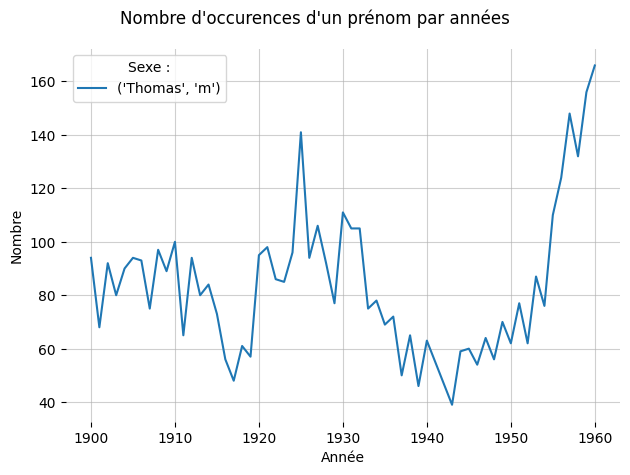

In [84]:
graphique_prenoms(
    prenoms=['Thomas'],
    genre=['m'],
    periode=[1900, 1960]
)

## Recherches<a id='5'></a>

---

In [82]:
df_prenoms.loc[(df_prenoms['prenom'] == 'Thomas') & (df_prenoms['genre'] == 'm'), 'nombre'].mean()

2283.0243902439024

In [85]:
test = df_prenoms[df_prenoms['genre'] == 'm']

In [103]:
# Prénom donné au moins 100 ans
temp = test.groupby('prenom', as_index=False)['annee'].agg('nunique')

prenoms = temp.loc[temp['annee'] >= 100, 'prenom']

test = test.loc[test['prenom'].isin(prenoms)]

In [69]:
def display_outliers_tab(sexe, position=['upper', 'lower']):
    """
    Affiche les prénoms outliers dans df_prenoms.
    Paramètres :
    - sexe : le sexe des prénoms à afficher('m' ou 'f')
    - position : la position des outlier à afficher.
    """

    df_temp = df_prenoms.loc[df_prenoms['sexe'] == sexe]
    df_temp = df_temp.groupby('prenom')['nombre'].sum().reset_index()

    # Calcul les bornes max/min
    Q1 = df_temp['nombre'].quantile(0.25)
    Q3 = df_temp['nombre'].quantile(0.75)
    IQR = Q3 - Q1
    max_boxplot = 1.5 * IQR + Q3
    min_boxplot = Q1 - 1.5 * IQR

    # Filtre les outliers
    if position == 'upper':
        return df_temp.loc[
            df_temp['nombre'] >= max_boxplot, ['prenom', 'nombre']
        ].sort_values(by='nombre', ascending=False)
    elif position == 'lower':
        return df_temp.loc[
            df_temp['nombre'] <= min_boxplot, ['prenom', 'nombre']
        ].sort_values(by='nombre')

In [72]:
def display_not_outliers(sexe):
    """
    Affiche les prénoms outliers dans df_prenoms.
    Paramètres :
    - sexe : le sexe des prénoms à afficher.
    - position : la position des outlier à afficher.
    """

    df_temp = df_prenoms.loc[df_prenoms['sexe'] == sexe]
    df_temp = df_temp.groupby('prenom')['nombre'].sum().reset_index()

    # Calcul les bornes max/min
    Q1 = df_temp['nombre'].quantile(0.25)
    Q3 = df_temp['nombre'].quantile(0.75)
    median = df_temp['nombre'].median()
    IQR = Q3 - Q1
    max_boxplot = 1.5 * IQR + Q3
    min_boxplot = Q1 - 1.5 * IQR

    return df_temp.loc[
        (df_temp['nombre'] >= median)
        & (df_temp['nombre'] <= max_boxplot)
    ].sort_values(by='nombre', ascending=False)